In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import cesm_orcas_sci as cesm
import cam
import gv
import metpy.calc as mcalc

import colorbrewer

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%%time
obs = xr.open_mfdataset(gv.flight_file)
obs['GGALT'] = obs.GGALT * 1e-3
obs.GGALT.attrs['units'] = 'km'
obs = obs.drop(['UTC','DOY'])
obs.info()

xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	datetime64[ns] time(time) ;
	float64 Year(time) ;
		Year:units = Year ;
		Year:long_name = Year ;
	float64 flt(time) ;
		flt:long_name = Flight number ;
	float64 ALTG_SRTM(time) ;
	float64 ATTACK(time) ;
		ATTACK:units = degree ;
		ATTACK:long_name = Attack Angle, Reference ;
	float64 ATX(time) ;
		ATX:units = deg_C ;
		ATX:long_name = Ambient Temperature, Reference ;
	float64 BLATA(time) ;
		BLATA:units = G ;
		BLATA:long_name = IRS Body Latitudal Acceleration ;
	float64 BLONGA(time) ;
		BLONGA:units = G ;
		BLONGA:long_name = IRS Body Longitudal Acceleration ;
	float64 BNORMA(time) ;
		BNORMA:units = G ;
		BNORMA:long_name = IRS Body Normal Acceleration ;
	float64 CONC2DCA_LWO(time) ;
		CONC2DCA_LWO:units = #/L ;
		CONC2DCA_LWO:long_name = Total Fast 2DC Concentration, All Particles ;
	float64 CONCD_LWI(time) ;
		CONCD_LWI:units = #/cm3 ;
		CONCD_LWI:long_name = CDP Concentration (all cells) ;
	float64 CONCN(time) ;
		CONCN:un

### Apply a mask to avoid land and points north of latitude boundary

mask points over land

In [3]:
lat_rgn = [-90.,-30.]
lon_rgn = [-180.,180.]

named_points = {
    'SCCI' : [-53.01062,-70.85168,42],
    'SCAR' : [-18.3483,-70.3386, 167],
    'SCTE' : [-41.438611, -73.0939, 294],
    'SCVD' : [-39.649722,-73.086111,59]}

airport_lon = np.array([v[1] for v in named_points.values()])
airport_lat = np.array([v[0] for v in named_points.values()])

def region_quality_mask(x,y,z):
    from earth_geometry import points_in_range

    #-- land_mask = within 10km of airport and below 4 km
    land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )

    #-- region_mask 
    region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )

    return ( land_mask & region_mask )


Verify application of mask: points in orange are included, points in blue have been removed

/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Text(0,0.5,'Altitude')

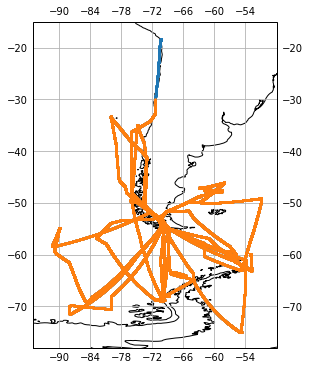

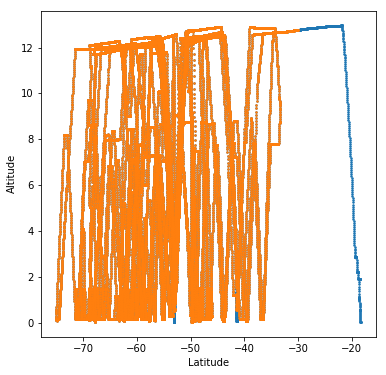

In [4]:
fig = plt.figure(figsize=(6,6))
crs_latlon = ccrs.PlateCarree()
ax = fig.add_subplot(111,projection=crs_latlon)
ax.set_extent([-95,-48,-78,-15],crs=crs_latlon)
ax.coastlines('50m')
ax.gridlines(draw_labels=True)

ax.plot(obs.GGLON,obs.GGLAT,'.',markersize=3,transform=crs_latlon)
ds = obs.where(region_quality_mask(obs.GGLON.values,obs.GGLAT.values,obs.GGALT.values))
ax.plot(ds.GGLON,ds.GGLAT,'.',markersize=3,transform=crs_latlon)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(obs.GGLAT,obs.GGALT,'.',markersize=3)
ax.plot(ds.GGLAT,ds.GGALT,'.',markersize=3)
ax.set_xlabel('Latitude')
ax.set_ylabel('Altitude')

Apply the mask

In [5]:
obs = obs.where(region_quality_mask(obs.GGLON.values,obs.GGLAT.values,obs.GGALT.values))

### bin data into lat-alt bins

In [6]:
%%time
alt_bins = np.arange(0.,14.,1.)
lat_bins = np.arange(-75.,-30.,5.)
binlat = lambda ds: ds.groupby_bins('GGLAT',lat_bins).mean()

obs_bin = obs.groupby_bins('GGALT',alt_bins).apply(binlat)

#obs_bin = obs_bin.where(obs.N2O_QCLS>326)
obs_bin['alt'] = xr.DataArray(np.vstack((alt_bins[0:-1],alt_bins[1:])).mean(axis=0),dims='GGALT_bins')
obs_bin['lat'] = xr.DataArray(np.vstack((lat_bins[0:-1],lat_bins[1:])).mean(axis=0),dims='GGLAT_bins')
print(obs_bin)

<xarray.Dataset>
Dimensions:         (GGALT_bins: 13, GGLAT_bins: 8)
Coordinates:
  * GGLAT_bins      (GGLAT_bins) object (-75.0, -70.0] (-70.0, -65.0] ...
  * GGALT_bins      (GGALT_bins) object (0.0, 1.0] (1.0, 2.0] (2.0, 3.0] ...
Data variables:
    Year            (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    flt             (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    ALTG_SRTM       (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    ATTACK          (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    ATX             (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    BLATA           (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    BLONGA          (GGALT_bins, GGLAT_bins) float64 dask.array<shape=(13, 8), chunksize=(13, 8)>
    BNORMA          (GGALT_bins, GGLAT_bins) float64 dask.array<s

In [7]:
obs_bin = obs_bin.compute()

/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


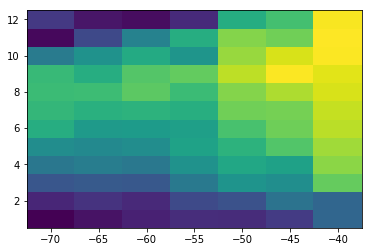

In [8]:
plt.pcolormesh(obs_bin.lat,obs_bin.alt,obs_bin.CO2_NOAA)

cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


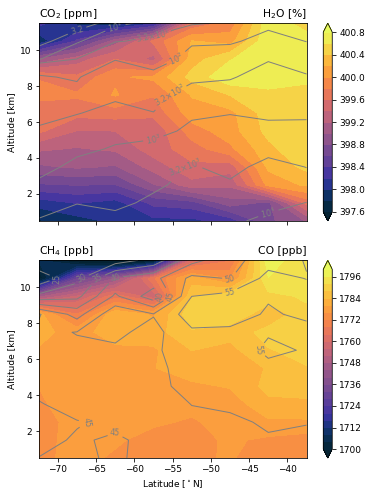

In [9]:
import plot_tools
import colorbrewer
import cmocean
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,8))

v = 'CO2_NOAA'
ax = fig.add_subplot(2,1,1)
ax.set_facecolor('gainsboro')
norm = plot_tools.MidPointNorm(midpoint=399.)
levels = plot_tools.nice_levels(397.5,400.8,20,outside=False)
cf = ax.contourf(obs_bin.lat, obs_bin.alt, obs_bin[v],
                 levels=levels,
                 cmap = cmocean.cm.thermal, #'viridis',
                 extend='both')

#cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.THETA,
#                 levels = np.arange(250.,350.,5.),
#                 colors = 'gray',
#                 linewidths = 1)

levels = 10**np.array(np.arange(0.5,5.5,0.5))
cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.H2O_NOAA,
                 levels = levels,
                 colors = 'gray',
                 linewidths = 1)

cs.levels = [val for val in cs.levels]
#fmt = '%r'
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
fmt = '%0.1e'
f = ticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))
#plt.gca().yaxis.set_major_formatter()

lb = plt.clabel(cs, fontsize=8,
                inline = True,
                fmt=ticker.FuncFormatter(g))

#cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf) #,cax=cbax)
#cb.set_label('[ppm]')

ax.set_title('CO$_2$ [ppm]',loc='left')
ax.set_title('H$_2$O [%]',loc='right')
ax.set_ylim([0.5,11.5])

ax.set_xticklabels([])
#ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Altitude [km]')

v = 'CH4_NOAA'
ax = fig.add_subplot(2,1,2)
ax.set_facecolor('gainsboro')

norm = plot_tools.MidPointNorm(midpoint=1780.)
levels = plot_tools.nice_levels(1700,1800.,30,outside=False)
cf = ax.contourf(obs_bin.lat, obs_bin.alt, obs_bin[v],
                 levels=levels,
                 #norm = norm,
                 cmap = cmocean.cm.thermal, #'viridis',
                 extend='both')

cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.CO_NOAA,
                 levels = np.arange(20.,65.,5.),
                 colors = 'gray',
                 linewidths = 1)


cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
fmt = '%r'
lb = plt.clabel(cs, fontsize=8,
                inline = True,
                fmt=fmt)

#cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf) #,cax=cbax)
#cb.set_label('[ppm]')

ax.set_title('CH$_4$ [ppb]',loc='left')
ax.set_title('CO [ppb]',loc='right')
ax.set_ylim([0.5,11.5])

ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Altitude [km]')

plt.savefig(os.path.join(diro['fig'],'scargo-xsection-co2-h2o-ch4-co.pdf'),dpi=300,bbox_inches='tight',
           transparent=True)

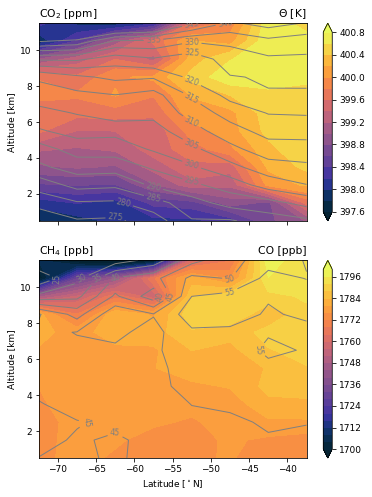

In [10]:
import plot_tools
import colorbrewer
import cmocean
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,8))

v = 'CO2_NOAA'
ax = fig.add_subplot(2,1,1)
ax.set_facecolor('gainsboro')
norm = plot_tools.MidPointNorm(midpoint=399.)
levels = plot_tools.nice_levels(397.5,400.8,20,outside=False)
cf = ax.contourf(obs_bin.lat, obs_bin.alt, obs_bin[v],
                 levels=levels,
                 cmap = cmocean.cm.thermal, #'viridis',
                 extend='both')

cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.THETA,
                 levels = np.arange(250.,350.,5.),
                 colors = 'gray',
                 linewidths = 1)

cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
fmt = '%r'
lb = plt.clabel(cs, fontsize=8,
                inline = True,
                fmt=fmt)

#cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf) #,cax=cbax)
#cb.set_label('[ppm]')

ax.set_title('CO$_2$ [ppm]',loc='left')
ax.set_title('$\Theta$ [K]',loc='right')
ax.set_ylim([0.5,11.5])

ax.set_xticklabels([])
#ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Altitude [km]')

v = 'CH4_NOAA'
ax = fig.add_subplot(2,1,2)
ax.set_facecolor('gainsboro')

norm = plot_tools.MidPointNorm(midpoint=1780.)
levels = plot_tools.nice_levels(1700,1800.,30,outside=False)
cf = ax.contourf(obs_bin.lat, obs_bin.alt, obs_bin[v],
                 levels=levels,
                 #norm = norm,
                 cmap = cmocean.cm.thermal, #'viridis',
                 extend='both')

cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.CO_NOAA,
                 levels = np.arange(20.,65.,5.),
                 colors = 'gray',
                 linewidths = 1)


cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
fmt = '%r'
lb = plt.clabel(cs, fontsize=8,
                inline = True,
                fmt=fmt)

#cbax = fig.add_axes([0.87,0.1,0.03,0.75])
cb = plt.colorbar(cf) #,cax=cbax)
#cb.set_label('[ppm]')

ax.set_title('CH$_4$ [ppb]',loc='left')
ax.set_title('CO [ppb]',loc='right')
ax.set_ylim([0.5,11.5])

ax.set_xlabel('Latitude [$^\circ$N]')
ax.set_ylabel('Altitude [km]')

plt.savefig(os.path.join(diro['fig'],'scargo-xsection-co2-theta-ch4-co.pdf'),dpi=300,bbox_inches='tight')

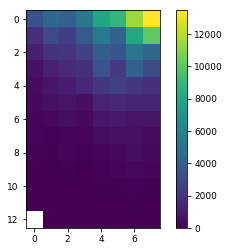

In [11]:
plt.imshow(obs_bin.H2O_NOAA); plt.colorbar()

/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:1483: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


(0.5, 11.5)

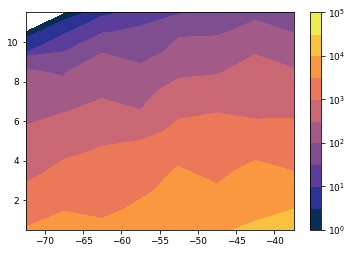

In [12]:
import plot_tools
import colorbrewer
import cmocean
import matplotlib.colors as colors

fig = plt.figure(figsize=(6,4))

v = 'H2O_NOAA'
ax = fig.add_subplot(1,1,1)

levels = 10**np.array(np.arange(-0,5.5,0.5))

cf = ax.contourf(obs_bin.lat, obs_bin.alt, obs_bin[v],
                 levels = levels,
                 norm = colors.LogNorm(vmin=levels[0],vmax=levels[-1]),
                 cmap = cmocean.cm.thermal)

#cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.THETA,
#                 levels = np.arange(250.,350.,5.),
#                 colors = 'gray',
#                 linewidths = 1)

#cs = ax.contour(obs_bin.lat, obs_bin.alt, obs_bin.H2O_NOAA,
#                 levels = np.arange(250.,350.,5.),
#                 colors = 'gray',
#                 linewidths = 1)
cb = plt.colorbar(cf) #,cax=cbax)

ax.set_ylim([0.5,11.5])

In [13]:
0.5*10**2

50.0

In [14]:
np.logspace(0.,5.5,len(levels))

array([1.00000000e+00, 3.54813389e+00, 1.25892541e+01, 4.46683592e+01,
       1.58489319e+02, 5.62341325e+02, 1.99526231e+03, 7.07945784e+03,
       2.51188643e+04, 8.91250938e+04, 3.16227766e+05])

In [34]:
lower_trop = np.array([2.,3.])
upper_trop = np.array([5,6.])
vg_bins = np.concatenate((lower_trop,upper_trop))

In [40]:
profiles = np.unique(obs.n_prof)
#vgt = xr.Dataset()
for n in profiles:
    if np.isnan(n): continue
    groups = obs.where(obs.n_prof==n).groupby_bins('GGALT',vg_bins)#.mean()
    try:
        binned = groups.mean()
        vgt = binned.isel(GGALT_bins=0) - binned.isel(GGALT_bins=-1)
    except: 
        continue
    print(vgt.CO2_NOAA.values)


nan
-1.0923076923076565
-0.3027692307692291
nan
-0.8146153846153084
-1.2492307692308486
-0.9667692307692164
-0.2246153846153902
-0.261538461538521
-0.5522222222222126
-0.46923076923064855
-0.4484615384615722
-0.8307692307692491
-0.08666666666670153
nan
nan
-0.6492857142856678
-1.3661904761904111
-0.22357142857151757
-0.5330769230769192
-0.4915178571428669
-0.5667857142857429
-0.6829059829058792
-0.47188034188036454
-0.6417582417582253
-0.720247252747356
-0.38164102564104496
nan
-0.7525824175824027
nan
-0.6730769230769056
-0.6750549450548533
-1.2691093117408627
-0.809596273291902
-0.7192307692307622
-0.5509340659340296
-0.6888461538461002
-0.9604977375565795
0.20886029411769869
-0.03132867132876527
-0.14538461538461434
0.09230769230765645
-0.42083333333329165
-0.31237179487186495
-0.5083333333332689
-0.6807692307692719
-0.4669230769230239
-0.8809999999999718
nan
nan
-1.5405555555555566
-1.0163701923077042
-0.6100549450549693
-0.9028571428571013
-0.697692307692364
-0.9226923076922731
-1.

In [33]:
obs.GGALT.values[1000]

4.1950134277